In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from matplotlib import pyplot as plt

plt.style.use("ggplot")



In [3]:
POSITIVE_CLASS = 1
BAG_COUNT = 1000
VAL_BAG_COUNT = 300
BAG_SIZE = 3
PLOT_SIZE = 3
ENSEMBLE_AVG_COUNT = 1

In [4]:

def create_bags(input_data, input_labels, positive_class, bag_count, instance_count):

    # Set up bags.
    bags = []
    bag_labels = []

    # Normalize input data.
    input_data = np.divide(input_data, 255.0)

    # Count positive samples.
    count = 0

    for _ in range(bag_count):

        # Pick a fixed size random subset of samples.
        index = np.random.choice(input_data.shape[0], instance_count, replace=False)
        instances_data = input_data[index]
        instances_labels = input_labels[index]

        # By default, all bags are labeled as 0.
        bag_label = 0

        # Check if there is at least a positive class in the bag.
        if positive_class in instances_labels:

            # Positive bag will be labeled as 1.
            bag_label = 1
            count += 1

        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))

    print(f"Positive bags: {count}")
    print(f"Negative bags: {bag_count - count}")

    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels))


# Load the MNIST dataset.
(x_train, y_train), (x_val, y_val) = keras.datasets.mnist.load_data()

# Create training data.
train_data, train_labels = create_bags(
    x_train, y_train, POSITIVE_CLASS, BAG_COUNT, BAG_SIZE
)

# Create validation data.
val_data, val_labels = create_bags(
    x_val, y_val, POSITIVE_CLASS, VAL_BAG_COUNT, BAG_SIZE
)

11501568/11490434 [==============================] - 0s 0us/step
Positive bags: 294
Negative bags: 706
Positive bags: 77
Negative bags: 223


In [5]:

class MILAttentionLayer(layers.Layer):
    """Implementation of the attention-based Deep MIL layer.

    Args:
      weight_params_dim: Positive Integer. Dimension of the weight matrix.
      kernel_initializer: Initializer for the `kernel` matrix.
      kernel_regularizer: Regularizer function applied to the `kernel` matrix.
      use_gated: Boolean, whether or not to use the gated mechanism.

    Returns:
      List of 2D tensors with BAG_SIZE length.
      The tensors are the attention scores after softmax with shape `(batch_size, 1)`.
    """

    def __init__(
        self,
        weight_params_dim,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        use_gated=False,
        **kwargs,
    ):

        super().__init__(**kwargs)

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

        self.v_init = self.kernel_initializer
        self.w_init = self.kernel_initializer
        self.u_init = self.kernel_initializer

        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer

    def build(self, input_shape):

        # Input shape.
        # List of 2D tensors with shape: (batch_size, input_dim).
        input_dim = input_shape[0][1]

        self.v_weight_params = self.add_weight(
            shape=(input_dim, self.weight_params_dim),
            initializer=self.v_init,
            name="v",
            regularizer=self.v_regularizer,
            trainable=True,
        )

        self.w_weight_params = self.add_weight(
            shape=(self.weight_params_dim, 1),
            initializer=self.w_init,
            name="w",
            regularizer=self.w_regularizer,
            trainable=True,
        )

        if self.use_gated:
            self.u_weight_params = self.add_weight(
                shape=(input_dim, self.weight_params_dim),
                initializer=self.u_init,
                name="u",
                regularizer=self.u_regularizer,
                trainable=True,
            )
        else:
            self.u_weight_params = None

        self.input_built = True

    def call(self, inputs):

        # Assigning variables from the number of inputs.
        instances = [self.compute_attention_scores(instance) for instance in inputs]

        # Apply softmax over instances such that the output summation is equal to 1.
        alpha = tf.math.softmax(instances, axis=0)

        return [alpha[i] for i in range(alpha.shape[0])]

    def compute_attention_scores(self, instance):

        # Reserve in-case "gated mechanism" used.
        original_instance = instance

        # tanh(v*h_k^T)
        instance = tf.math.tanh(tf.tensordot(instance, self.v_weight_params, axes=1))

        # for learning non-linear relations efficiently.
        if self.use_gated:

            instance = instance * tf.math.sigmoid(
                tf.tensordot(original_instance, self.u_weight_params, axes=1)
            )

        # w^T*(tanh(v*h_k^T)) / w^T*(tanh(v*h_k^T)*sigmoid(u*h_k^T))
        return tf.tensordot(instance, self.w_weight_params, axes=1)


The bag class label is positive
Bag number: 0


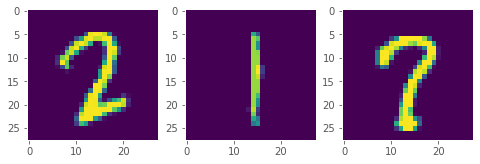

Bag number: 1


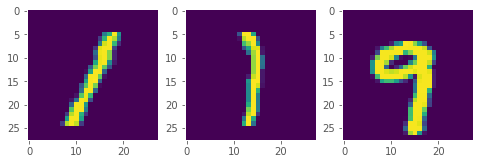

Bag number: 2


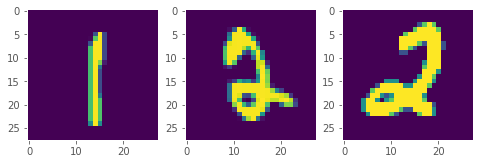

The bag class label is negative
Bag number: 3


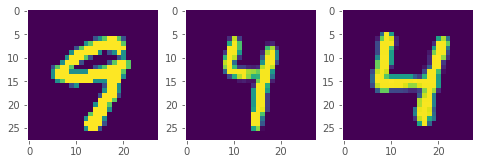

Bag number: 4


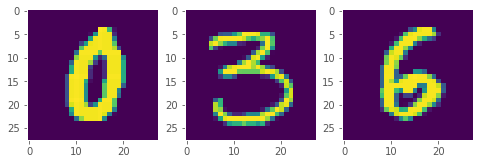

Bag number: 5


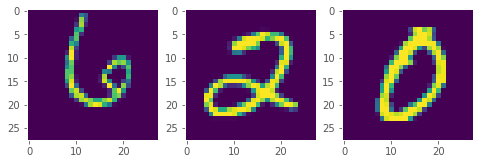

In [6]:

def plot(data, labels, bag_class, predictions=None, attention_weights=None):

    """"Utility for plotting bags and attention weights.

    Args:
      data: Input data that contains the bags of instances.
      labels: The associated bag labels of the input data.
      bag_class: String name of the desired bag class.
        The options are: "positive" or "negative".
      predictions: Class labels model predictions.
      If you don't specify anything, ground truth labels will be used.
      attention_weights: Attention weights for each instance within the input data.
      If you don't specify anything, the values won't be displayed.
    """

    labels = np.array(labels).reshape(-1)

    if bag_class == "positive":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

        else:
            labels = np.where(labels == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    elif bag_class == "negative":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
        else:
            labels = np.where(labels == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    else:
        print(f"There is no class {bag_class}")
        return

    print(f"The bag class label is {bag_class}")
    for i in range(PLOT_SIZE):
        figure = plt.figure(figsize=(8, 8))
        print(f"Bag number: {labels[i]}")
        for j in range(BAG_SIZE):
            image = bags[j][i]
            figure.add_subplot(1, BAG_SIZE, j + 1)
            plt.grid(False)
            if attention_weights is not None:
                plt.title(np.around(attention_weights[labels[i]][j], 2))
            plt.imshow(image)
        plt.show()


# Plot some of validation data bags per class.
plot(val_data, val_labels, "positive")
plot(val_data, val_labels, "negative")

In [7]:

def create_model(instance_shape):

    # Extract features from inputs.
    inputs, embeddings = [], []
    shared_dense_layer_1 = layers.Dense(128, activation="relu")
    shared_dense_layer_2 = layers.Dense(64, activation="relu")
    for _ in range(BAG_SIZE):
        inp = layers.Input(instance_shape)
        flatten = layers.Flatten()(inp)
        dense_1 = shared_dense_layer_1(flatten)
        dense_2 = shared_dense_layer_2(dense_1)
        inputs.append(inp)
        embeddings.append(dense_2)

    # Invoke the attention layer.
    alpha = MILAttentionLayer(
        weight_params_dim=256,
        kernel_regularizer=keras.regularizers.l2(0.01),
        use_gated=True,
        name="alpha",
    )(embeddings)

    # Multiply attention weights with the input layers.
    multiply_layers = [
        layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))
    ]

    # Concatenate layers.
    concat = layers.concatenate(multiply_layers, axis=1)

    # Classification output node.
    output = layers.Dense(2, activation="softmax")(concat)

    return keras.Model(inputs, output)


In [8]:

def compute_class_weights(labels):

    # Count number of postive and negative bags.
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count

    # Build class weight dictionary.
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2),
    }


In [9]:

def train(train_data, train_labels, val_data, val_labels, model):

    # Train model.
    # Prepare callbacks.
    # Path where to save best weights.

    # Take the file name from the wrapper.
    file_path = "/tmp/best_model_weights.h5"

    # Initialize model checkpoint callback.
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        file_path,
        monitor="val_loss",
        verbose=0,
        mode="min",
        save_best_only=True,
        save_weights_only=True,
    )

    # Initialize early stopping callback.
    # The model performance is monitored across the validation data and stops training
    # when the generalization error cease to decrease.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, mode="min"
    )

    # Compile model.
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"],
    )

    # Fit model.
    model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=20,
        class_weight=compute_class_weights(train_labels),
        batch_size=1,
        callbacks=[early_stopping, model_checkpoint],
        verbose=0,
    )

    # Load best weights.
    model.load_weights(file_path)

    return model


# Building model(s).
instance_shape = train_data[0][0].shape
models = [create_model(instance_shape) for _ in range(ENSEMBLE_AVG_COUNT)]

# Show single model architecture.
print(models[0].summary())

# Training model(s).
trained_models = [
    train(train_data, train_labels, val_data, val_labels, model)
    for model in tqdm(models)
]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['input_1[0][0]']                
                                                                                              

100%|██████████| 1/1 [00:41<00:00, 41.13s/it]


The average loss and accuracy are 0.06 and 98.67 % resp.
The bag class label is positive
Bag number: 0


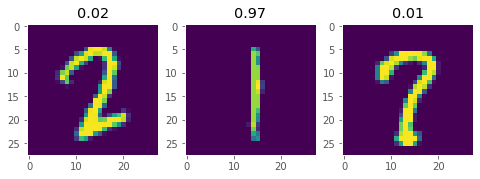

Bag number: 1


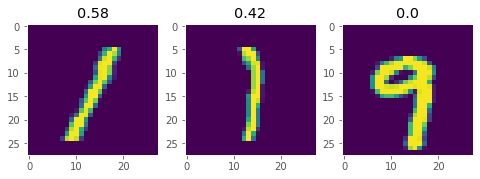

Bag number: 2


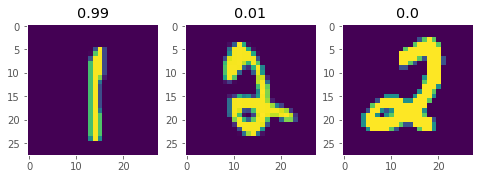

The bag class label is negative
Bag number: 3


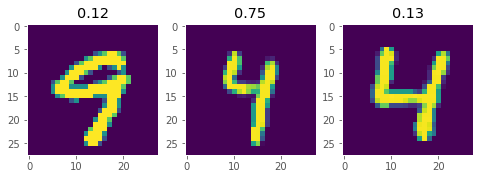

Bag number: 4


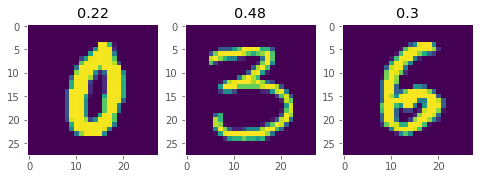

Bag number: 5


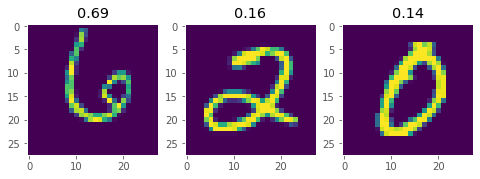

In [10]:

def predict(data, labels, trained_models):

    # Collect info per model.
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []

    for model in trained_models:

        # Predict output classes on data.
        predictions = model.predict(data)
        models_predictions.append(predictions)

        # Create intermediate model to get MIL attention layer weights.
        intermediate_model = keras.Model(model.input, model.get_layer("alpha").output)

        # Predict MIL attention layer weights.
        intermediate_predictions = intermediate_model.predict(data)

        attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
        models_attention_weights.append(attention_weights)

        loss, accuracy = model.evaluate(data, labels, verbose=0)
        models_losses.append(loss)
        models_accuracies.append(accuracy)

    print(
        f"The average loss and accuracy are {np.sum(models_losses, axis=0) / ENSEMBLE_AVG_COUNT:.2f}"
        f" and {100 * np.sum(models_accuracies, axis=0) / ENSEMBLE_AVG_COUNT:.2f} % resp."
    )

    return (
        np.sum(models_predictions, axis=0) / ENSEMBLE_AVG_COUNT,
        np.sum(models_attention_weights, axis=0) / ENSEMBLE_AVG_COUNT,
    )


# Evaluate and predict classes and attention scores on validation data.
class_predictions, attention_params = predict(val_data, val_labels, trained_models)

# Plot some results from our validation data.
plot(
    val_data,
    val_labels,
    "positive",
    predictions=class_predictions,
    attention_weights=attention_params,
)
plot(
    val_data,
    val_labels,
    "negative",
    predictions=class_predictions,
    attention_weights=attention_params,
)